My goal is to explore the data using the different plot packages in Python.

In [1]:
import os
os.listdir('input')

['NBA All Star Games (1).xlsx', 'NBA All Stars 2000-2016 - Sheet1.csv']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline

import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
from plotly import subplots
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Some functions used to import the data and to apply simple transformation to them

In [3]:
def get_data(path):
    df = pd.read_csv(path)
    col_names = ['Year','Player','Pos','HT','WT','Team','SelectionType','NBADraft','Nationality']
    df.columns = col_names

    return df

def change_nationality(df):
    
    df['Nationality'] = np.where(df['Nationality'] != 'United States','Rest of World',df['Nationality'])
    
    return df

def change_team(df):
    df['Team'] = np.where(df['Team'] == 'New Jersey Nets','Brooklyn Nets',df['Team'])
    df['Team'] = np.where(df['Team'] == 'New Orleans Hornets','New Orleans Pelicans',df['Team'])
    df['Team'] = np.where(df['Team'] == 'Charlotte Bobcats','Charlotte Hornets',df['Team'])
    df['Team'] = np.where(df['Team'] == 'Seattle SuperSonics','Oklahoma City Thunder',df['Team'])
    
    return df

In [4]:
df = get_data('input/NBA All Stars 2000-2016 - Sheet1.csv')

In [5]:
df

,Year,Player,Pos,HT,WT,Team,SelectionType,NBADraft,Nationality
0,2016,Stephen Curry,G,6-3,190,Golden State Warriors,Western All-Star Fan Vote Selection,2009 Rnd 1 Pick 7,United States
1,2016,James Harden,SG,6-5,220,Houston Rockets,Western All-Star Fan Vote Selection,2009 Rnd 1 Pick 3,United States
2,2016,Kevin Durant,SF,6-9,240,Golden State Warriors,Western All-Star Fan Vote Selection,2007 Rnd 1 Pick 2,United States
3,2016,Kawhi Leonard,F,6-7,230,San Antonio Spurs,Western All-Star Fan Vote Selection,2011 Rnd 1 Pick 15,United States
4,2016,Anthony Davis,PF,6-11,253,New Orleans Pelicans,Western All-Star Fan Vote Selection,2012 Rnd 1 Pick 1,United States
...,...,...,...,...,...,...,...,...,...
434,2000,Antonio McDyess,F,6-9,245,Denver Nuggets,Western All-Star Coaches Selection,1995 Rnd 1 Pick 2,United States
435,2000,Gary Payton,G,6-4,180,Seattle SuperSonics,Western All-Star Coaches Selection,1990 Rnd 1 Pick 2,United States
436,2000,Rasheed Wallace,FC,6-11,230,Portland Trail Blazers,Western All-Star Coaches Selection,1995 Rnd 1 Pick 4,United States
437,2000,David Robinson,C,7-1,250,San Antonio Spurs,Western All-Star Coaches Selection,1987 Rnd 1 Pick 1,United States


### Data Cleaning

I decided to apply some transformation to the data:

* Split the column **NBA Draft** into three columns, **DraftYear**, **Round** and **Pick**
* Modifify the **Round** column in order to have the right values for special cases (e.g undrafted)
* Moodify the **Pos** column in order to use the same Position for each year.
* Modify the **Nationality** column in order not to have mixed cases (I have decided to divide into United States and Rest Of World)
* Modify the **Team** column in order to have the 30 team that are existing now in the NBA. (Please don't feel it personal if your favourite team will not be in analysis, I am a fan of the Seattle SuperSonics, it's hard to do it even for me )

In [6]:
df['Round'] = df['NBADraft'].str.split(' ').apply(lambda x: x[2])
df['Pick'] = df['NBADraft'].str.split(' ').apply(lambda x: x[-1])
df['Round'] = np.where(df['Round'] == 'Draft,','Undrafted',df['Round'])
df['DraftYear'] = df['NBADraft'].str.split(' ').apply(lambda x: x[0]).astype(np.int64)
df.drop('NBADraft',axis = 1, inplace = True)

real_position = {'SF':'F','F-C':'F','PG':'G','SG':'G',
                 'G-F':'G','G':'G','F':'F','C':'C','GF':'F',
                 'FC':'F','PF':'F'}
df['Pos'] = df['Pos'].map(real_position)

df = change_nationality(df)
df = change_team(df)

# correct one row
df['Conference'] = np.where(df.SelectionType.str.startswith("Eastern"),"East","West")
df['Conference'] = np.where(df.Team.str.startswith("New Orleans"),"West",df.Conference)

So now we can take a look at the dataset used in the following analysis.

In [7]:
df.head(10)

,Year,Player,Pos,HT,WT,Team,SelectionType,Nationality,Round,Pick,DraftYear,Conference
0,2016,Stephen Curry,G,6-3,190,Golden State Warriors,Western All-Star Fan Vote Selection,United States,1,7,2009,West
1,2016,James Harden,G,6-5,220,Houston Rockets,Western All-Star Fan Vote Selection,United States,1,3,2009,West
2,2016,Kevin Durant,F,6-9,240,Golden State Warriors,Western All-Star Fan Vote Selection,United States,1,2,2007,West
3,2016,Kawhi Leonard,F,6-7,230,San Antonio Spurs,Western All-Star Fan Vote Selection,United States,1,15,2011,West
4,2016,Anthony Davis,F,6-11,253,New Orleans Pelicans,Western All-Star Fan Vote Selection,United States,1,1,2012,West
5,2016,Russell Westbrook,G,6-3,200,Oklahoma City Thunder,Western All-Star Coaches Selection,United States,1,4,2008,West
6,2016,DeMarcus Cousins,C,6-11,270,Sacramento Kings,Western All-Star Coaches Selection,United States,1,5,2010,West
7,2016,Klay Thompson,G,6-7,215,Golden State Warriors,Western All-Star Coaches Selection,United States,1,11,2011,West
8,2016,Draymond Green,F,6-7,230,Golden State Warriors,Western All-Star Coaches Selection,United States,2,5,2012,West
9,2016,Marc Gasol,C,7-1,255,Memphis Grizzlies,Western All-Star Coaches Selection,Rest of World,2,18,2007,West


In [8]:
df.isnull().sum()

Year             0
Player           0
Pos              0
HT               0
WT               0
Team             0
SelectionType    0
Nationality      0
Round            0
Pick             0
DraftYear        0
Conference       0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           439 non-null    int64 
 1   Player         439 non-null    object
 2   Pos            439 non-null    object
 3   HT             439 non-null    object
 4   WT             439 non-null    int64 
 5   Team           439 non-null    object
 6   SelectionType  439 non-null    object
 7   Nationality    439 non-null    object
 8   Round          439 non-null    object
 9   Pick           439 non-null    object
 10  DraftYear      439 non-null    int64 
 11  Conference     439 non-null    object
dtypes: int64(3), object(9)
memory usage: 41.3+ KB


## Teams Analysis

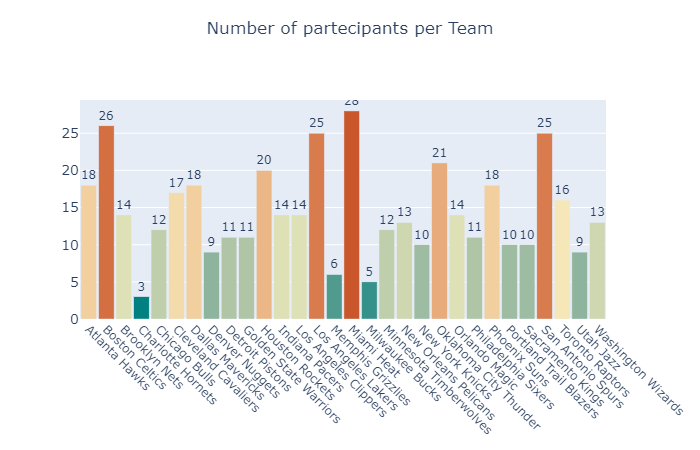

In [38]:
teams_count = pd.DataFrame(df.groupby('Team').size()).reset_index()
teams_count.columns = ['Team','Count']

fig = go.Figure()
fig.add_trace(go.Bar(x = teams_count.Team,
                     y = teams_count.Count,
                     text = teams_count.Count,
                     marker=dict(
                      color=teams_count.Count,
                      colorscale='geyser',
                  ),))

fig.update_traces(texttemplate='%{text:s}', textposition='outside')
fig.update_layout(
    title={'text': 'Number of partecipants per Team',
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=12,
    xaxis=dict(tickangle=45),
    yaxis=dict(
        titlefont_size=16,
        tickfont_size=14,
    ),
    showlegend = False,
    barmode='stack',
    bargap=0.1,
    bargroupgap=0.01
)
fig.update_xaxes(type='category',categoryorder='category ascending')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

By looking at the barplot we saw that the most famous and winning teams(*Los Angeles Lakers* and *Boston Celtics*) have a high number of partecipant during the period. Same can be said for the *San Antonio Spurs* who won $5$ titles during this period. However the team with most representative are the *Miami Heat*, which is highly influenced by the title won in 2006 (*Shaquille O'Neal* + *Dwayne Wade*) *Big Three Era*.

Even now the *Golden State Warriors* litereally dominated the last seasons, they did not get enough partecipation to be ranked among the best one and this is due to the fact that they were not a good team until now. Instead we can see the *Pheonix Suns* that are ranked among the best, which is due to good and spectacular team that they have in the first part of the 2000s.

Not suprising is to see some teams with very low partecipation overall, just like *Milwaukee Bucks*, *Memphis Grizzles* and *Charlotte Hornets*.

In the next plot you will see the number of partecipation per *Year* for each *Team*, divided by *Conference*.

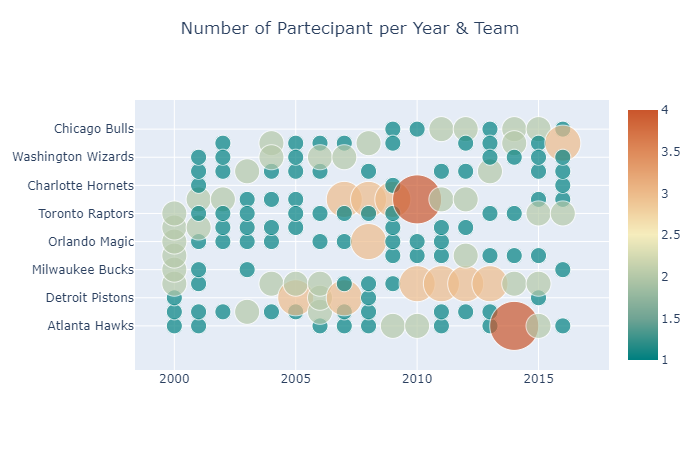

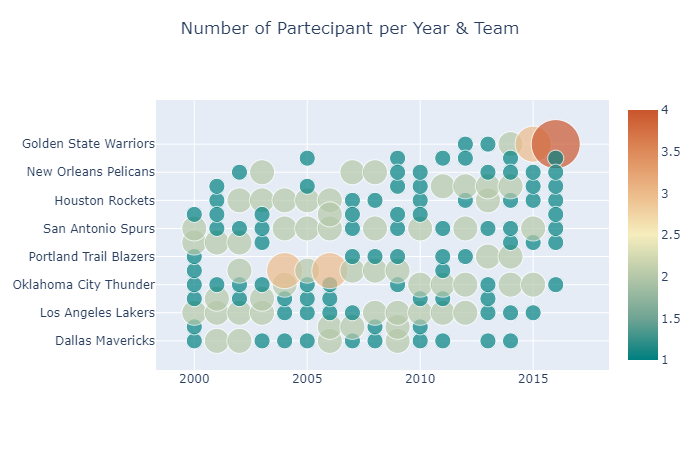

In [43]:
df_TY = pd.DataFrame(df.groupby(['Year','Team']).size()).reset_index()
df_TY.columns = ['Year','Team','Count']
map_TC = df[['Team','Conference']].drop_duplicates().set_index('Team').to_dict()['Conference']
df_TY['Conference'] = df_TY.Team.map(map_TC)

df_TY_east = df_TY.loc[df_TY['Conference'] == 'East']
df_TY_west = df_TY.loc[df_TY['Conference'] == 'West']


fig = go.Figure()

fig.add_trace(go.Scatter(x = df_TY_east.Year,
                  y = df_TY_east.Team,
                  marker=dict(
                      size=(df_TY_east.Count+3)**2,
                      color=df_TY_east.Count,
                      colorscale='geyser',
                      showscale=True,
                  ),
                  name = 'East',
                  mode = 'markers',
                  text = df_TY_east.Count))

fig.update_layout(title={'text': 'Number of Partecipant per Year & Team',
                     'y':0.95, 'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              showlegend=False,
              height = 750,
              xaxis=dict(
                  categoryorder='category ascending',
              ),
              yaxis=dict(
                  titlefont_size=12,
                  tickfont_size=12,
              ),
             )

fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = df_TY_west.Year,
                  y = df_TY_west.Team,
                  marker=dict(
                      size=(df_TY_west.Count+3)**2,
                      color=df_TY_west.Count,
                      colorscale='geyser',
                      showscale=True,
                  ),
                  name = 'West',
                  mode = 'markers',
                  text = df_TY_west.Count)
)


fig2.update_layout(title={'text': 'Number of Partecipant per Year & Team',
                     'y':0.95, 'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              showlegend=False,
              height = 750,
              xaxis=dict(
                  categoryorder='category ascending',
              ),
              yaxis=dict(
                  titlefont_size=12,
                  tickfont_size=12,
              ),
             )

fig.show('png')
fig2.show('png')

By focusing on the **Eastern Conference** stands out some *Teams* like the *Detroit Pistons*, *Boston Celtics* and *Atlanta Hawks*. While the first two are characterized by big names, titles and "Big Three", the Atlanta Hawks were just in a good season, in which they reach the first seed in East, but they did not win the title.

Switching to the **Western Conference** the only two teams which steal the spotlight are the **Golden State Warriors**, which shows clearly when they became a strong team, since in the first years they did not get any representation. Remarkable results also for the **Pheonix Suns**, even though they lost representation going on with the years.
Despite being one of the best team for all the period 2000-2016, the **San Antonio Spurs** did not reach 3 components in any year.

Let's take a look at the position and let's check if they changed over the years.

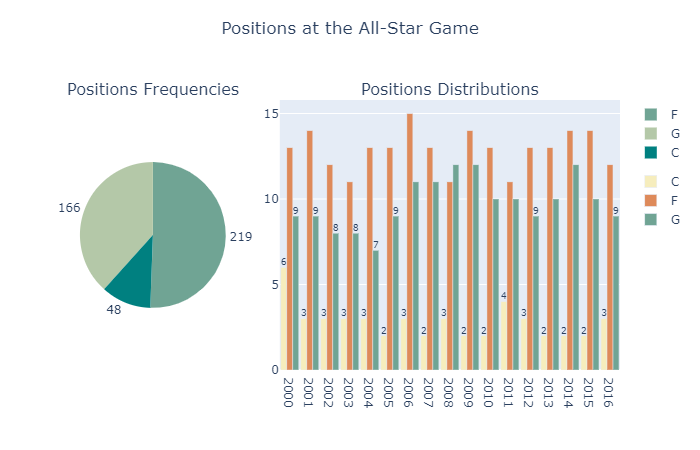

In [52]:
df_Pos = pd.DataFrame(df.groupby('Pos').size()).reset_index()
df_Pos.columns = ['Pos','Count']
df_Pos_Year = pd.DataFrame(df.groupby(['Year','Pos']).size()).reset_index()
df_Pos_Year.columns = ['Year','Pos','Count']


def color_selection(pos):
    if pos == 'G':
        color = 'rgb(112, 164, 148)'
    elif pos == 'F':
        color = 'rgb(222, 138, 90)'
    else:
        color = 'rgb(246, 237, 189)'
    return color

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {}]],
    column_widths=[0.3, 0.7],
    subplot_titles=('Positions Frequencies',
                    'Positions Distributions'))

fig.add_trace(
    go.Pie(
        labels = df_Pos.Pos,
        values = df_Pos.Count,
        name = 'Positions',
        text = df_Pos.Count,
        hoverinfo='label+percent+name',
        textinfo= 'percent+label+text',
        textposition = 'inside',
        marker = dict(
            colors = plotly.colors.diverging.Geyser,
        ),
        legendgroup='pie'
    ),
    row = 1,
    col = 1
)

for pos in df_Pos_Year.Pos.unique():

    fig.add_trace(
        go.Bar(
            x=df_Pos_Year.loc[df_Pos_Year['Pos'] == pos].Year,
            y=df_Pos_Year.loc[df_Pos_Year['Pos'] == pos].Count,
            name=pos,
            text = df_Pos_Year.loc[df_Pos_Year['Pos'] == pos].Count,
            texttemplate='%{text:f}',
            textposition='inside',
            legendgroup='bar',
            marker=dict(
                      color=color_selection(pos),
                      colorscale='geyser',
                     ),
        ),
        row = 1,
        col = 2,
    )


fig.update_traces(texttemplate='%{text:s}', textposition='outside')
fig.update_layout(
    title={'text': "Positions at the All-Star Game",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    
    xaxis_tickfont_size=12,
    yaxis2=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_Pos_Year.Count.max()*1.2]
    ),
    height = 500,
    showlegend = True,
    barmode='group',
    bargap=0.1,
    bargroupgap=0.01 
)
fig.update_xaxes(type='category',categoryorder='category ascending')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

By looking at the barplot seems that the number of *Center position* descrease each year.

Let's see how the selection method changed over the years.

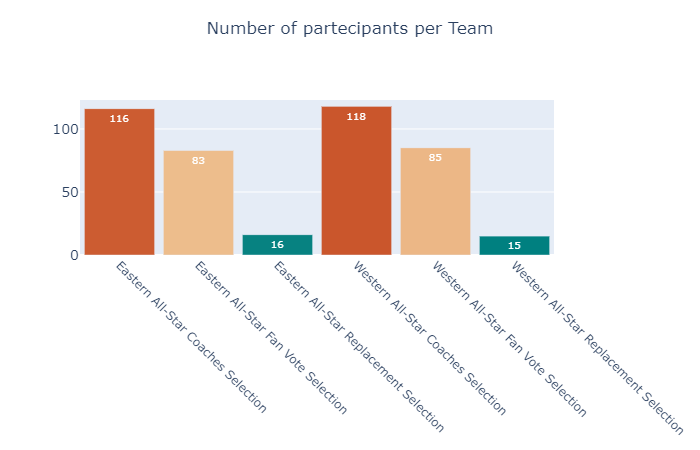

In [51]:
df_ST = pd.DataFrame(df.groupby(['SelectionType']).size()).reset_index()
df_ST.columns = ['SelectionType','Count']

fig = go.Figure()
fig.add_trace(go.Bar(x = df_ST.SelectionType,
                     y = df_ST.Count,
                     text = df_ST.Count,
                     marker=dict(
                      color=df_ST.Count,
                      colorscale='geyser',
                     ),
                    )
             )

fig.update_traces(texttemplate='%{text:s}', textposition='inside')
fig.update_layout(
    title={'text': 'Number of partecipants per Team',
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=12,
    xaxis=dict(tickangle=45),
    yaxis=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_ST.Count.max()+5]
    ),
    height = 500,
    showlegend = False,
    barmode='stack',
    bargap=0.1,
    bargroupgap=0.01 
)
fig.update_xaxes(type='category',categoryorder='category ascending')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

It is clear that the Selectino method did not changed much and the frequencies of each kind are the same.

## Players Analysis

First I want to focus on the draft Pick, hoping to see some if this is relevant to the All-Start Status of a Player.

In [15]:
df.head()

,Year,Player,Pos,HT,WT,Team,SelectionType,Nationality,Round,Pick,DraftYear,Conference
0,2016,Stephen Curry,G,6-3,190,Golden State Warriors,Western All-Star Fan Vote Selection,United States,1,7,2009,West
1,2016,James Harden,G,6-5,220,Houston Rockets,Western All-Star Fan Vote Selection,United States,1,3,2009,West
2,2016,Kevin Durant,F,6-9,240,Golden State Warriors,Western All-Star Fan Vote Selection,United States,1,2,2007,West
3,2016,Kawhi Leonard,F,6-7,230,San Antonio Spurs,Western All-Star Fan Vote Selection,United States,1,15,2011,West
4,2016,Anthony Davis,F,6-11,253,New Orleans Pelicans,Western All-Star Fan Vote Selection,United States,1,1,2012,West


In [16]:
df.Round.value_counts()

1            406
2             26
Undrafted      6
3              1
Name: Round, dtype: int64

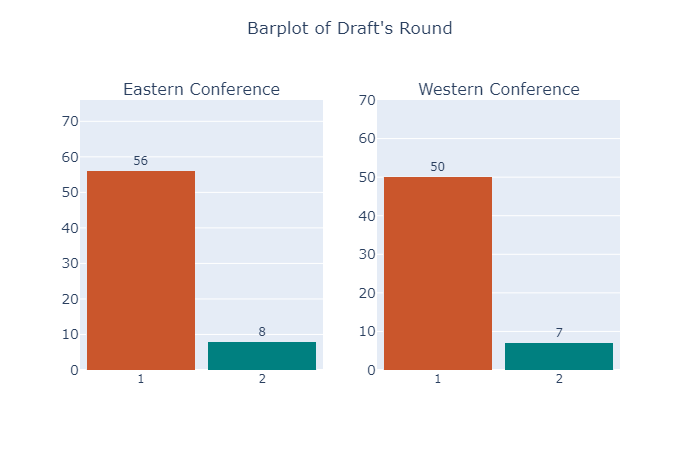

In [44]:
df['Round'] = df.Round.astype('str')


df_R_east = pd.DataFrame(df.drop_duplicates('Player').loc[df['Conference'] == 'East'].groupby(['Round']).size()).reset_index()
df_R_east.columns = ['Round','Count']

df_R_west = pd.DataFrame(df.drop_duplicates('Player').loc[df['Conference'] == 'West'].groupby(['Round']).size()).reset_index()
df_R_west.columns = ['Round','Count']


fig = make_subplots(
    rows=1, cols=2,
    specs=[[{}, {}]],
    subplot_titles=('Eastern Conference',
                    'Western Conference'))
fig.add_trace(
    go.Bar(
        x = df_R_east.Round,
        y = df_R_east.Count,
        text = df_R_east.Count,
        marker=dict(color=df_R_east.Count,
                    colorscale='geyser',
                  ),
        name = 'East',
    ),
    row = 1,
    col = 1,
)

fig.add_trace(
    go.Bar(
        x = df_R_west.Round,
        y = df_R_west.Count,text = df_R_west.Count,
        marker=dict(color=df_R_west.Count,
                    colorscale='geyser',
                   ),
        name = 'West',
    ),
    row = 1,
    col = 2,
)

fig.update_traces(texttemplate='%{text:s}', textposition='outside')
fig.update_layout(
    title={'text': "Barplot of Draft's Round",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    
    xaxis_tickfont_size=12,
    yaxis1=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_R_east.Count.max()+20]
    ),
    yaxis2=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_R_west.Count.max()+20]
    ),
    height = 500,
    showlegend = False,
    barmode='stack',
    bargap=0.1,
    bargroupgap=0.01 
)
fig.update_xaxes(type='category',categoryorder='category ascending')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

Not surprisingly at all is that the most of the partecipant was selected during the first *Round* of the Draft. The count for the $2^{nd}$ round is pretty much the same for both Conferences.

It is important to state that the $3^{rd}$ is now not used anymore, so we can consider that player as a $2^{nd}$ round pick.

Let's see who were the player that went **Undrafted** but still made the **All-Star Game**.

In [18]:
df.drop_duplicates('Player').loc[df['Round'] == 'Undrafted']

,Year,Player,Pos,HT,WT,Team,SelectionType,Nationality,Round,Pick,DraftYear,Conference
309,2005,Ben Wallace,F,6-9,240,Detroit Pistons,Eastern All-Star Coaches Selection,United States,Undrafted,Undrafted,1996,East
346,2003,Brad Miller,C,7-0,261,Sacramento Kings,Western All-Star Coaches Selection,United States,Undrafted,Undrafted,1998,West


In [19]:
df.loc[df['Round'] == 'Undrafted'].groupby('Player').size()

Player
Ben Wallace    4
Brad Miller    2
dtype: int64

Interestingly enough, the only $2$ player to be selected as *Undrafted* were **Ben Wallace** and **Brad Miller** and they were selected more than once.

Now let's take a look into the **Pick** of each partecipant. In order to make the *Pick* useful, I multiply the value for the round, in order to have a fair distribution ($1^{st}$ pick of first and second round are very different). 

Furthermore I decided to divide the pick into buckets, as follows:
* 1-5 pick position
* 6-10 pick position
* 11 - 20 pick position
* 21 - 30 pick position
* 31 - 45 pick position
* 46 - 60 pick position

In [20]:
df['Round'] = np.where(df['Round'] == '3','2',df['Round'])
df = df.loc[df['Round'] != 'Undrafted']
df.Round = df.Round.astype(np.int64)
df.Pick = df.Pick.astype(np.int64)

df['RealPick'] = df[['Round', 'Pick']].prod(axis=1)

condlist = [(df.RealPick.values<=5),
            (df.RealPick.values>5) & (df.RealPick.values<=10),
            (df.RealPick.values>10) & (df.RealPick.values<=20),
            (df.RealPick.values>20) & (df.RealPick.values<=30),
            (df.RealPick.values>30) & (df.RealPick.values<=45),
            (df.RealPick.values>45)]
choicelist = ['1-5','6-10','11-20','21-30','31-45','45-60']
df['PickGroup'] = np.select(condlist, choicelist)

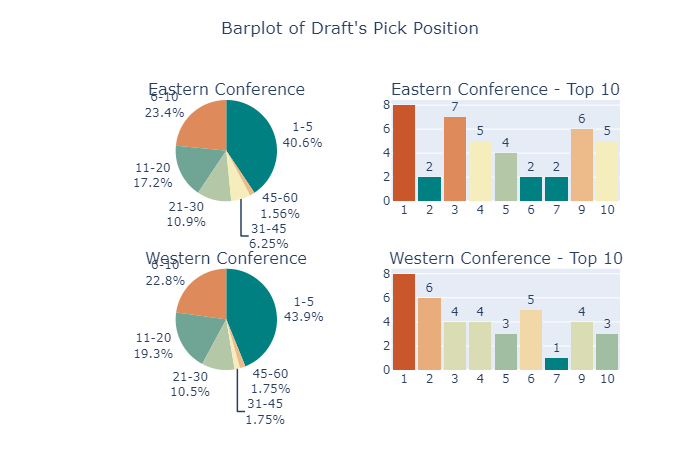

In [45]:
df['Round'] = df.Round.astype('str')


df_P_east = pd.DataFrame(df.drop_duplicates('Player').loc[df['Conference'] == 'East'].groupby(['PickGroup']).size()).reset_index()
df_P_east.columns = ['PickGroup','Count']

df_P_west = pd.DataFrame(df.drop_duplicates('Player').loc[df['Conference'] == 'West'].groupby(['PickGroup']).size()).reset_index()
df_P_west.columns = ['PickGroup','Count']


df_P10_east = pd.DataFrame(df.drop_duplicates('Player').loc[(df['Conference'] == 'East') & (df['RealPick'] <= 10)].groupby(['RealPick']).size()).reset_index()
df_P10_east.columns = ['Pick10','Count']

df_P10_west = pd.DataFrame(df.drop_duplicates('Player').loc[(df['Conference'] == 'West') & (df['RealPick'] <= 10)].groupby(['RealPick']).size()).reset_index()
df_P10_west.columns = ['Pick10','Count']


fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type':'pie'}, {}],
           [{'type':'pie'},{}]],
    subplot_titles=('Eastern Conference',
                    'Eastern Conference - Top 10',
                    'Western Conference',
                    'Western Conference - Top 10'))

fig.add_trace(
    go.Pie(
        labels = df_P_east.PickGroup,
        values = df_P_east.Count,
        name = 'East',
        text = df_P_east.Count,
        hoverinfo='label+percent+name',
        textinfo= 'percent+label',
        textposition = 'outside',
        marker = dict(
            colors = plotly.colors.diverging.Geyser,
        )
    ),
    row = 1,
    col = 1
)


fig.add_trace(
    go.Pie(
        labels = df_P_west.PickGroup,
        values = df_P_west.Count,
        name = 'West',
        text = df_P_west.Count,
        hoverinfo='label+percent+name',
        textinfo= 'percent+label',
        textposition = 'outside',
        marker = dict(
            colors = plotly.colors.diverging.Geyser,
        )
    ),
    row = 2,
    col = 1
)

fig.add_trace(
    go.Bar(
        x = df_P10_east.Pick10,
        y = df_P10_east.Count,
        text = df_P10_east.Count,
        marker=dict(color=df_P10_east.Count,
                    colorscale='geyser',
                  ),
        texttemplate='%{text:s}',
        textposition='outside',
        name = 'East top 10',
    ),
    row = 1,
    col = 2,
)


fig.add_trace(
    go.Bar(
        x = df_P10_west.Pick10,
        y = df_P10_west.Count,
        text = df_P10_west.Count,
        marker=dict(color=df_P10_west.Count,
                    colorscale='geyser',
                  ),
        texttemplate='%{text:s}',
        textposition='outside',
        name = 'West top 10'
    ),
    row = 2,
    col = 2,
)

fig.update_layout(
    title={'text': "Barplot of Draft's Pick Position",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    
    xaxis_tickfont_size=12,
    yaxis3=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_P10_west.Count.max()*1.3]
    ),
    yaxis4=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_P10_west.Count.max()*1.3]
    ),
    height = 1000,
    showlegend = False,
    barmode='stack',
    bargap=0.1,
    bargroupgap=0.01 
)
fig.update_xaxes(type='category',
                 categoryorder='array',
                 categoryarray = ['1-5','6-10','11-20','21-30','31-45','45-60'])
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

By looking at the plot, it's clear that the most of the *Player* are being selected in the first Pick of the first Round, especially for the first $5$ picks. There is not differences between the $2$ *Conferences*.

Let's take a look about how many player were selected for in the first $5$ years of they career.

In [22]:
df.sort_values(by = 'Year', inplace = True)
df_s = df.drop_duplicates('Player',keep='first')
df_s['GapASG'] = np.subtract(df_s['Year'],df_s['DraftYear'])

In [23]:
df_s.head(10)

,Year,Player,Pos,HT,WT,Team,SelectionType,Nationality,Round,Pick,DraftYear,Conference,RealPick,PickGroup,GapASG
438,2000,Vlade Divac,C,7-1,260,Sacramento Kings,Western All-Star Replacement Selection,Rest of World,1,26,1989,West,26,21-30,11
411,2000,Allen Iverson,G,6-0,165,Philadelphia Sixers,Eastern All-Star Fan Vote Selection,United States,1,1,1996,East,1,1-5,4
412,2000,Tracy McGrady,F,6-8,210,Orlando Magic,Eastern All-Star Fan Vote Selection,United States,1,9,1997,East,9,6-10,3
413,2000,Vince Carter,F,6-6,220,Toronto Raptors,Eastern All-Star Fan Vote Selection,United States,1,5,1998,East,5,1-5,2
414,2000,Alonzo Mourning,C,6-10,240,Miami Heat,Eastern All-Star Fan Vote Selection,United States,1,2,1992,East,2,1-5,8
415,2000,Grant Hill,F,6-8,225,Orlando Magic,Eastern All-Star Fan Vote Selection,United States,1,3,1994,East,3,1-5,6
416,2000,Ray Allen,G,6-5,205,Milwaukee Bucks,Eastern All-Star Coaches Selection,United States,1,5,1996,East,5,1-5,4
417,2000,Antonio Davis,F,6-9,245,Toronto Raptors,Eastern All-Star Replacement Selection,United States,2,18,1990,East,36,31-45,10
418,2000,Theo Ratliff,C,6-10,235,Philadelphia Sixers,Eastern All-Star Coaches Selection,United States,1,18,1995,East,18,11-20,5
419,2000,Glenn Robinson,F,6-7,225,Milwaukee Bucks,Eastern All-Star Coaches Selection,United States,1,1,1994,East,1,1-5,6


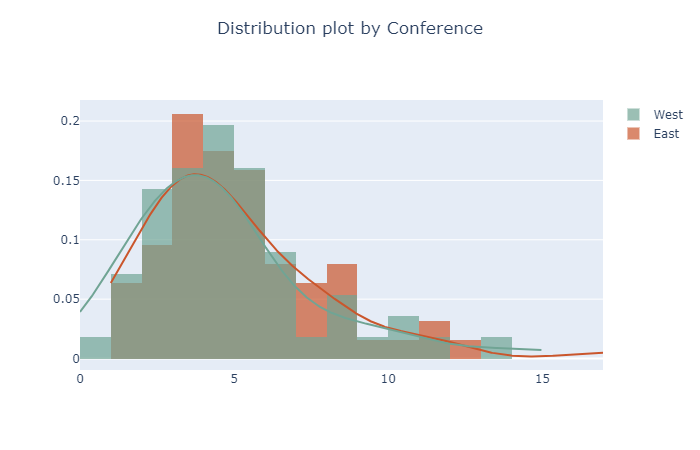

In [53]:
import numpy as np

gap_east = df_s.loc[df_s['Conference'] == "East"].GapASG
gap_west = df_s.loc[df_s['Conference'] == "West"].GapASG

hist_data = [gap_east, gap_west]

group_labels = ['East', 'West']

# Create distplot with custom bin_size
fig = ff.create_distplot(
    hist_data,
    group_labels,
    bin_size=1,
    show_rug=False,
    colors = ['rgb(202, 86, 44)', 'rgb(112, 164, 148)'],
)

fig.update_layout(
    title={'text': "Distribution plot by Conference",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    
    height = 700,
    showlegend = True,
)


fig.show('png')

It does not seems that there are any difference between the distribution of the $2$ population. It seems also that usually the players participate for the first time, but there are some exceptions. Some players have their first appearance from the first years ($22$ players between the first $2$ years) and some only at the end of the careers.


Let's start with the latent one.

In [25]:
df_s.loc[df_s['GapASG'] >= 10].sort_values(by = 'GapASG')

,Year,Player,Pos,HT,WT,Team,SelectionType,Nationality,Round,Pick,DraftYear,Conference,RealPick,PickGroup,GapASG
417,2000,Antonio Davis,F,6-9,245,Toronto Raptors,Eastern All-Star Replacement Selection,United States,2,18,1990,East,36,31-45,10
435,2000,Gary Payton,G,6-4,180,Oklahoma City Thunder,Western All-Star Coaches Selection,United States,1,2,1990,West,2,1-5,10
347,2003,Sam Cassell,G,6-3,185,Minnesota Timberwolves,Western All-Star Coaches Selection,United States,1,24,1993,West,24,21-30,10
438,2000,Vlade Divac,C,7-1,260,Sacramento Kings,Western All-Star Replacement Selection,Rest of World,1,26,1989,West,26,21-30,11
121,2012,Tyson Chandler,C,7-1,240,New York Knicks,Eastern All-Star Coaches Selection,United States,1,2,2001,East,2,1-5,11
62,2014,Kyle Korver,F,6-7,212,Atlanta Hawks,Eastern All-Star Replacement Selection,United States,2,22,2003,East,44,31-45,11
422,2000,Anthony Mason,F,6-7,250,Miami Heat,Eastern All-Star Coaches Selection,United States,2,3,1988,East,6,6-10,12
437,2000,David Robinson,C,7-1,250,San Antonio Spurs,Western All-Star Coaches Selection,United States,1,1,1987,West,1,1-5,13
433,2000,Karl Malone,F,6-9,265,Utah Jazz,Western All-Star Coaches Selection,United States,1,13,1985,West,13,11-20,15
397,2001,Michael Jordan,G,6-6,215,Washington Wizards,Eastern All-Star Fan Vote Selection,United States,1,3,1984,East,3,1-5,17


By looking at them, most are not at their first experience (looking at the name it is pretty obvious), but only at the first of the time period considered. From the group above, only *Vlade Divac*, *Sam Cassel*, *Tyson Chandler*, *Kyle Korver* and *Anthony Mason* have actually their first experience at the All-Star Game.

Let's focus on the youngest one now.

Below you can see some plots regarding this analysis.

In [26]:
df_s.loc[df_s['GapASG'] < 3].sort_values(by = 'GapASG')

,Year,Player,Pos,HT,WT,Team,SelectionType,Nationality,Round,Pick,DraftYear,Conference,RealPick,PickGroup,GapASG
373,2002,Yao Ming,C,7-6,310,Houston Rockets,Western All-Star Fan Vote Selection,Rest of World,1,1,2002,West,1,1-5,0
90,2013,Anthony Davis,F,6-11,253,New Orleans Pelicans,Western All-Star Replacement Selection,United States,1,1,2012,West,1,1-5,1
126,2012,Kyrie Irving,G,6-3,193,Cleveland Cavaliers,Eastern All-Star Coaches Selection,Rest of World,1,1,2011,East,1,1-5,1
163,2010,Blake Griffin,F,6-10,251,Los Angeles Clippers,Western All-Star Coaches Selection,United States,1,1,2009,West,1,1-5,1
331,2004,Dwyane Wade,G,6-4,220,Miami Heat,Eastern All-Star Coaches Selection,United States,1,5,2003,East,5,1-5,1
325,2004,LeBron James,F,6-8,250,Cleveland Cavaliers,Eastern All-Star Fan Vote Selection,United States,1,1,2003,East,1,1-5,1
199,2009,Derrick Rose,G,6-3,190,Chicago Bulls,Eastern All-Star Coaches Selection,United States,1,1,2008,East,1,1-5,1
79,2013,Damian Lillard,G,6-3,195,Portland Trail Blazers,Western All-Star Coaches Selection,United States,1,6,2012,West,6,6-10,1
236,2007,Brandon Roy,G,6-6,211,Portland Trail Blazers,Western All-Star Coaches Selection,United States,1,6,2006,West,6,6-10,1
123,2012,Paul George,F,6-9,220,Indiana Pacers,Eastern All-Star Coaches Selection,United States,1,10,2010,East,10,6-10,2


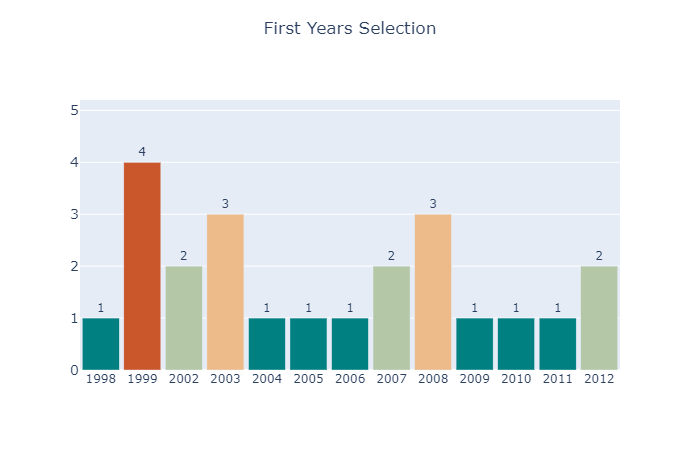

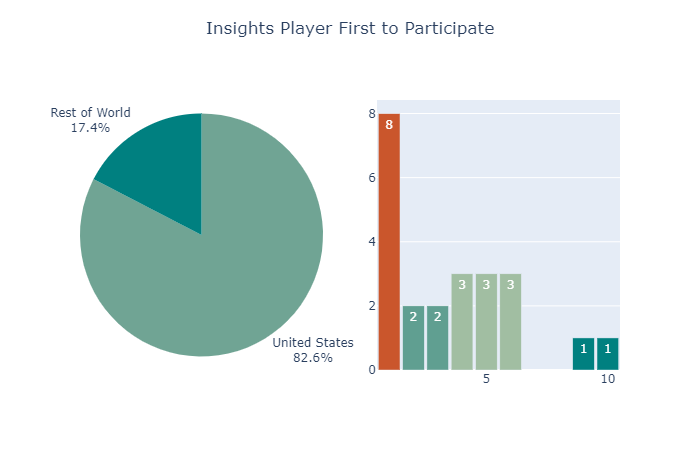

In [47]:
df_1 = pd.DataFrame(df_s.loc[df_s['GapASG'] < 3].groupby('DraftYear').size()).reset_index()
df_1.columns = ['Year','Count']
df_2 = pd.DataFrame(df_s.loc[df_s['GapASG'] < 3].groupby('Nationality').size()).reset_index()
df_2.columns = ['Nationality','Count']
df_2 = pd.DataFrame(df_s.loc[df_s['GapASG'] < 3].groupby('Nationality').size()).reset_index()
df_2.columns = ['Nationality','Count']
df_3 = pd.DataFrame(df_s.loc[df_s['GapASG'] < 3].groupby('Pick').size()).reset_index()
df_3.columns = ['Pick','Count']


fig2 = go.Figure()

fig2.add_trace(
    go.Bar(
        x = df_1.Year,
        y = df_1.Count,
        text = df_1.Count,
        marker=dict(color=df_1.Count,
                    colorscale='geyser',
                  ),
        texttemplate='%{text:s}',
        textposition='outside',
        name = 'East top 10',
    ),
)

fig2.update_layout(
    title={'text': "First Years Selection",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    
    xaxis_tickfont_size=12,
    yaxis=dict(
        titlefont_size=16,
        tickfont_size=14,
        range = [0,df_1.Count.max()*1.3],
    ),
    height = 700,
    showlegend = False,
    barmode='stack',
    bargap=0.1,
    bargroupgap=0.01,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)
fig2.update_xaxes(type='category',
                 categoryorder='array',
                 categoryarray = ['1-5','6-10','11-20','21-30','31-45','45-60'])
fig2.update_layout()
fig2.show('png')


fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type":"domain"},{}]],
    subplot_titles=('',
                    '',
                    ))


fig.add_trace(
    go.Pie(
        labels = df_s.loc[df_s['GapASG'] < 3].groupby('Nationality').size().index,
        values = df_s.loc[df_s['GapASG'] < 3].groupby('Nationality').size().values,
        name = 'Nationality',
        text = df_s.loc[df_s['GapASG'] < 3].groupby('Nationality').size().values,
        hoverinfo='label+percent+name',
        textinfo= 'percent+label',
        textposition = 'outside',
        marker = dict(
            colors = plotly.colors.diverging.Geyser,
        ),
    ),
    row = 1,
    col = 1
)


fig.add_trace(
    go.Bar(
        x = df_3.Pick,
        y = df_3.Count,
        text = df_3.Count,
        marker=dict(color=df_3.Count,
                    colorscale='geyser',
                  ),
        texttemplate='%{text:s}',
        textposition='inside',
        name = 'Draft Pick',
    ),
    row = 1,
    col = 2,
)


fig.update_layout(
    title={'text': "Insights Player First to Participate",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=12,
    height = 800,
    showlegend = False,
    barmode='stack',
    bargap=0.1,
    bargroupgap=0.01 
)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')

It's clear that the **Draft** of $1999$, $2003$ and $2008$ were rich of great player, since they are the group with the higest number of partecipation. By looking at the PiePlot seems that for players coming from outside the USA is more difficult to shine during the firsts NBA Season enough to be selected for the ASG (**Luka Doncic** for example would be in this list).
Looking at the last barplot, we can say that more player were first pick during the draft but also that some player were drafted from the $4^{th}$ to the $6^{th}$ seed.

Let's see now which of this player have more appereances, i.e which one mantained this status during the year.

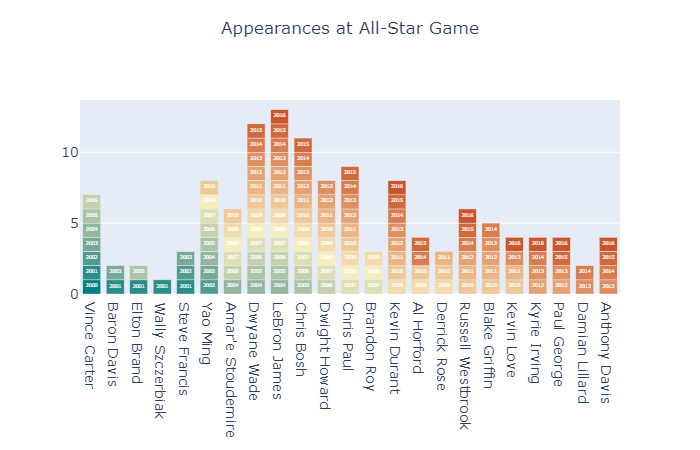

In [48]:
players_first  = df_s.loc[df_s['GapASG'] < 3].Player

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df.loc[df['Player'].isin(players_first)].Player,
        y=df.loc[df['Player'].isin(players_first)].Round,
        name='Partecipation',
        marker=dict(
            color = df.loc[df['Player'].isin(players_first)].Year,
            colorscale = 'geyser'
        ),
        text = df.loc[df['Player'].isin(players_first)].Year.astype('category'),
        texttemplate='%{text:f}',
        textposition='inside',
    )
)
        
fig.update_layout(
    title={'text': "Appearances at All-Star Game",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)
fig.show('png')

It 's interesting to see that the player with most presence are the *Big Three* from Miami all drafted in the $2003$. By scrolling over the plot is possible to see that there are few players that have missed some years, like *Kyrie Irving* or *Kevin Love*.

Let's now check which player have more appearances. 

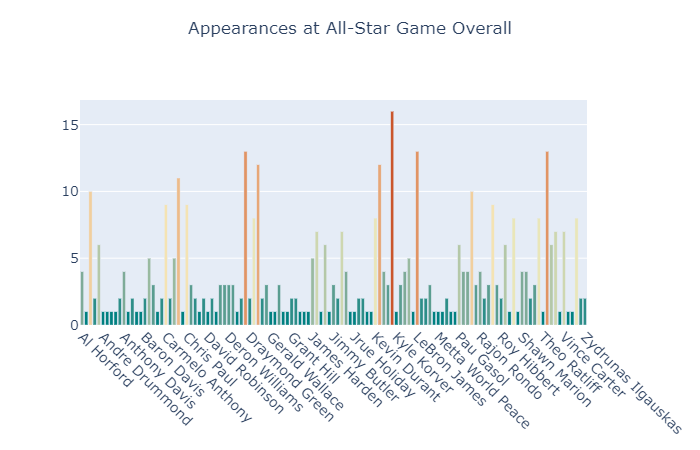

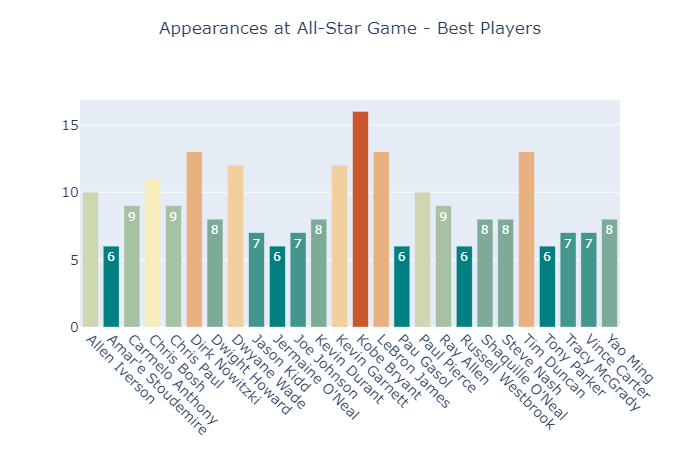

In [49]:
df_p = pd.DataFrame(df.groupby('Player').size()).reset_index()
df_p.columns = ['Player','Count']

df_p.loc[df_p['Count']>5]

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df_p.Player,
        y=df_p.Count,
        name='Player',
        marker=dict(
            color = df_p.Count,
            colorscale = 'geyser'
        ),
        text = df_p.Count,
        texttemplate='%{text:s}',
        textposition='inside',
    )
)
        
fig.update_layout(
    title={'text': "Appearances at All-Star Game Overall",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=14,
    xaxis=dict(tickangle=45),
    yaxis=dict(
        title='',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='stack',
    bargap=0.15,
    bargroupgap=0.1,
    width = 2000
)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show('png')



fig2 = go.Figure()
fig2.add_trace(
    go.Bar(
        x=df_p.loc[df_p['Count']>5].Player,
        y=df_p.loc[df_p['Count']>5].Count,
        name='Player',
        marker=dict(
            color = df_p.loc[df_p['Count']>5].Count,
            colorscale = 'geyser'
        ),
        text = df_p.loc[df_p['Count']>5].Count,
        texttemplate='%{text:s}',
        textposition='inside',
    )
)
        
fig2.update_layout(
    title={'text': "Appearances at All-Star Game - Best Players",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=14,
    xaxis=dict(tickangle=45),
    yaxis=dict(
        title='',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='stack',
    bargap=0.15,
    bargroupgap=0.1,
    width = 20000
)
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig2.show('png')

At last now, I want to see how the nationality of the players changed over the years.

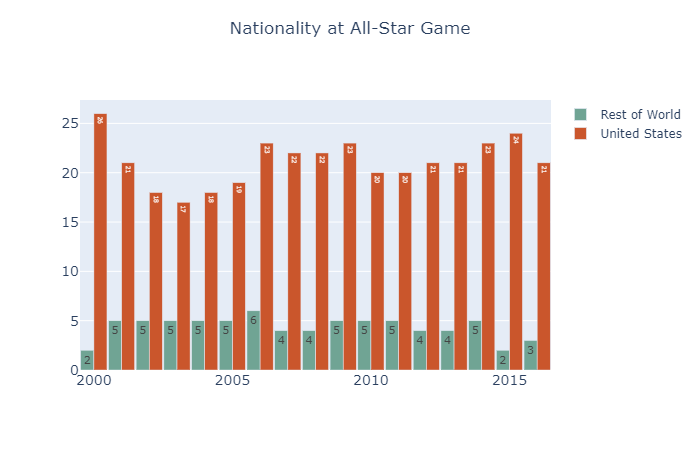

In [50]:
df_Nat = (df.groupby(['Year','Nationality']).size()).reset_index()
df_Nat.columns = ['Year','Nationality','Count']

def color_selection(nat):
    if nat == 'United States':
        color = 'rgb(202, 86, 44)'
    else:
        color = 'rgb(112, 164, 148)'

        
    return color


fig = go.Figure()

for nat in df_Nat.Nationality.unique():
    fig.add_trace(
        go.Bar(
            x=df_Nat.loc[df_Nat['Nationality'] == nat].Year,
            y=df_Nat.loc[df_Nat['Nationality'] == nat].Count,
            name=nat,
            marker=dict(
                color = color_selection(nat),
                colorscale = 'geyser'
            ),
            text = df_Nat.loc[df_Nat['Nationality'] == nat].Count,
            texttemplate='%{text:f}',
            textposition='inside',
        )
    )
        
fig.update_layout(
    title={'text': "Nationality at All-Star Game",
           'y':0.95,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='',
        titlefont_size=16,
        tickfont_size=14,
    ),
    barmode='group',
    bargap=0.05,
    bargroupgap=0.01
)
fig.show('png')

It does not seem that the number of *Players* coming from outside the United States is increasing